# Movie Review Sentiment Classification using RNNs


For the baseline model, we will build an RNN to classify positive vs negative movie reviews.


In [ ]:
!pip install datasets
!pip install kaggle
!pip install -U transformers
!pip install -U huggingface_hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1. Data

Use Kaggle CLI to import datasets

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38           4007         78  1.0              
mexwell/heart-disease-dataset                         🫀 Heart Disease Dataset                             399KB  2024-04-08 09:43:49           2175         39  1.0              
asaniczka/university-employee-salaries-2011-present   University Employee Salaries (2011 - Present)        17MB  2024-04-07 10:11:15           1720         48  1.0              
fatemehmehrparvar/obesity-levels                      Obesity Levels                                       58K

Download the datasets and load into notebook

In [ ]:
!kaggle datasets download -d djilax/allocine-french-movie-reviews
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 99% 46.0M/46.2M [00:00<00:00, 116MB/s] 
100% 46.2M/46.2M [00:00<00:00, 101MB/s]
 35% 9.00M/25.7M [00:00<00:00, 80.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 133MB/s] 


In [ ]:
!makdir project
!unzip /content/allocine-french-movie-reviews.zip -d project
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip -d project

/bin/bash: line 1: makdir: command not found
Archive:  /content/allocine-french-movie-reviews.zip
  inflating: project/test.csv        
  inflating: project/train.csv       
  inflating: project/valid.csv       
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: project/IMDB Dataset.csv  


In [ ]:
import transformers
from datasets import load_metric, load_dataset, DatasetDict, concatenate_datasets
import random, os, json
from transformers import AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorWithPadding, AutoModelForSequenceClassification
import torch
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load two datasets
eng_dataset = load_dataset("csv", data_files="./project/IMDB Dataset.csv")
fre_dataset = load_dataset("csv", data_files="./project/train.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Random sampling `count_per_lang` number data

In [ ]:
count_per_lang = 5000

eng_ind = sorted(random.sample(range(0, len(eng_dataset['train'])), count_per_lang))
fre_ind = sorted(random.sample(range(0, len(fre_dataset['train'])), count_per_lang))
eng_data = eng_dataset['train'].select(eng_ind)
fre_data = fre_dataset['train'].select(fre_ind)
print(f"After sampling: ENG {eng_data} FRE {fre_data}\n\n")

After sampling: ENG Dataset({
    features: ['review', 'sentiment'],
    num_rows: 5000
}) FRE Dataset({
    features: ['Unnamed: 0', 'film-url', 'review', 'polarity'],
    num_rows: 5000
})




In [ ]:
def label_to_number(example):
    ''' Convert 'positive' to 1, 'negative' to 0. '''
    example['sentiment'] = 1 if example['sentiment'] == 'positive' else 0
    return example

# Apply the conversion to each example in the dataset
eng_data = eng_data.map(label_to_number)

# Rename dataset column and only keep useful columns
fre_data = fre_data.rename_column('polarity', 'sentiment')
fre_data = fre_data.select_columns(['review', 'sentiment'])

print(f"After renaming: ENG {eng_data} FRE {fre_data}\n\n")

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

After renaming: ENG Dataset({
    features: ['review', 'sentiment'],
    num_rows: 5000
}) FRE Dataset({
    features: ['review', 'sentiment'],
    num_rows: 5000
})




Number of positive and negative reviews in the dataset

In [ ]:
from collections import Counter
print(Counter(x for x in eng_data['sentiment']))
print(Counter(x for x in fre_data['sentiment']))

Counter({1: 2535, 0: 2465})
Counter({0: 2593, 1: 2407})


Split dataset into train, validation, test following 8:1:1

In [ ]:
# Split off the test + validation dataset (20%)
test_val_split_eng = eng_data.train_test_split(test_size=0.2)
# Split the test + validation data equally into test and validation datasets
final_splits_eng = test_val_split_eng['test'].train_test_split(test_size=0.5)
# Gather splits into a single DatasetDict
eng_data = DatasetDict({
    'train': test_val_split_eng['train'],  # 80% of the original dataset
    'validation': final_splits_eng['train'],  # 10% of the original dataset
    'test': final_splits_eng['test']  # 10% of the original dataset
})
# Implement same way on French dataset
test_val_split_fre = fre_data.train_test_split(test_size=0.2)
final_splits_fre = test_val_split_fre['test'].train_test_split(test_size=0.5)
fre_data = DatasetDict({
    'train': test_val_split_fre['train'],
    'validation': final_splits_fre['train'],
    'test': final_splits_fre['test']
})
print(eng_data, fre_data)

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 500
    })
}) DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 500
    })
})


Display data samples

In [ ]:
print(eng_data['train'][4])
print(fre_data['train'][0])

{'review': 'The film has no connection with the real life in Bosnia in those days. Should be more realistic and shows the viewer real traumas that were happening to common people during the war. Please see some films of Yugoslav authors (Emir Kusturica, Ljubisa Samardzic,...e.g. Bure baruta( A barrel of powder), Tito i ja (Tito and me), Lepa sela lepo gore (Beautiful Villages burn Beautiful), etc... Just this is the real way to know about so called Bosnian problem. Hollywood is definitive not th right address to make films about the Balcan peninsula. Maybe Vietnam, WW II,... but not of the Slavs living in former Yugoslavia.', 'sentiment': 0}
{'review': 'Un beau film, tout en nuances, bonne idée de mise en scène.', 'sentiment': 1}


In [ ]:
### Check if CUDA is available
global device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU instead.")

GPU is not available. Using CPU instead.


Convert reviews into sequences of numbers.

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from datasets import DatasetDict

eng_tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for row in data:
        yield eng_tokenizer(row['review'])

# Build English vocabulary
eng_vocab = build_vocab_from_iterator(
    yield_tokens(eng_data['train']),
    specials=['<bos>', '<eos>', '<unk>', '<pad>']
)
eng_vocab.set_default_index(eng_vocab["<unk>"])

def tokenize(dataset, tokenizer, vocab):
    tokens = tokenizer(dataset["review"])
    token_ids = [vocab[token] for token in tokens]
    token_ids.insert(0, 0)
    token_ids.append(1)
    return {'tokenized_ids': token_ids}

eng_data = eng_data.map(
    lambda dataset: tokenize(dataset, eng_tokenizer, eng_vocab)
)
print(eng_data)
print(eng_data['train']['review'][0])
print(eng_data['train']['tokenized_ids'][0])


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 500
    })
})
I won't be too hard on this show because I enjoyed the first season, but then, things got worse. The concept is nothing special, just about a girl named Casey who is trying to cope with a new step-brother, Derek, and his loud, crude family, while she gradually forces her princess standards onto each of them.<br /><br />In season 1, the story was actually interesting. I liked Casey back then because she was smart, strong, independent, and conservative. She was well-mannered and deep. I felt bad when she was being harassed at her new school by her new step-brother. She was a perfectionist, but not as annoying as the later episodes. Oh, and sh

To tokenize French

In [ ]:
!pip install spacy
!python -m spacy download fr_core_news_sm

import spacy
nlp = spacy.load("fr_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 50.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def spacy_french_tokenizer(text):
    return [token.text for token in nlp(text)]

fre_tokenizer = get_tokenizer(spacy_french_tokenizer)

# Build Frech vocabulary
fre_vocab = build_vocab_from_iterator(
    yield_tokens(fre_data['train']),
    specials=['<bos>', '<eos>', '<unk>', '<pad>']
)
fre_vocab.set_default_index(fre_vocab["<unk>"])

fre_data = fre_data.map(
    lambda dataset: tokenize(dataset, fre_tokenizer, fre_vocab)
)
print(fre_data)
print(fre_data['train']['review'][0])
print(fre_data['train']['tokenized_ids'][0])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'tokenized_ids'],
        num_rows: 500
    })
})
Un beau film, tout en nuances, bonne idée de mise en scène.
[0, 2, 150, 14, 5, 45, 19, 7088, 5, 133, 243, 7, 108, 19, 77, 4, 1]


In [ ]:
# Print the number of words in the vocabulary
print(len(eng_vocab), len(fre_vocab))

# Convert a review into a sequence of word indices.
eng_review = 'The movie Pneumonoultramicroscopicsilicovolcanoconiosis is a good movie, it is very funny'
tokens = eng_tokenizer(f'<bos> {eng_review} <eos>')
print(tokens)
indices = eng_vocab.forward(tokens)
print(indices)

fre_review = 'Le film Pneumonoultramicroscopiquesilicovolcanoconiose est un bon film, il est très drôle'
tokens = fre_tokenizer(fre_review)
print(tokens)
indices = fre_vocab.forward(tokens)
print(indices)

40182 30038
['<bos>', 'the', 'movie', 'pneumonoultramicroscopicsilicovolcanoconiosis', 'is', 'a', 'good', 'movie', ',', 'it', 'is', 'very', 'funny', '<eos>']
[0, 4, 22, 2, 12, 8, 60, 22, 6, 13, 12, 63, 158, 1]
['Le', 'film', 'Pneumonoultramicroscopiquesilicovolcanoconiose', 'est', 'un', 'bon', 'film', ',', 'il', 'est', 'très', 'drôle']
[2, 14, 2, 12, 11, 66, 14, 5, 30, 12, 40, 224]


Convert DatasetDict to list

In [ ]:
def dataset_to_list(dataset):
    return [(row['tokenized_ids'], row['sentiment']) for row in dataset]
eng_train_data_indices = dataset_to_list(eng_data['train'])
eng_val_data_indices = dataset_to_list(eng_data['validation'])
eng_test_data_indices = dataset_to_list(eng_data['test'])
print(len(eng_train_data_indices), len(eng_val_data_indices), len(eng_test_data_indices))
print(eng_train_data_indices[4])

fre_train_data_indices = dataset_to_list(fre_data['train'])
fre_val_data_indices = dataset_to_list(fre_data['validation'])
fre_test_data_indices = dataset_to_list(fre_data['test'])
print(len(fre_train_data_indices), len(fre_val_data_indices), len(fre_test_data_indices))
print(fre_train_data_indices[0])

4000 500 500
([0, 4, 25, 54, 67, 1827, 23, 4, 160, 126, 14, 13105, 14, 157, 536, 5, 154, 36, 61, 796, 7, 279, 4, 548, 160, 20929, 17, 79, 1206, 10, 1147, 82, 301, 4, 304, 5, 595, 74, 57, 115, 9, 40027, 6397, 27, 26892, 14261, 6, 31089, 35725, 6, 5, 5, 5, 954, 5, 1625, 5, 24094, 23258, 27, 8, 5912, 9, 12124, 26, 6, 12581, 15, 30115, 27, 12581, 7, 77, 26, 6, 30907, 36096, 30908, 698, 27, 330, 10733, 3820, 330, 26, 6, 561, 5, 5, 5, 50, 16, 12, 4, 160, 105, 10, 130, 53, 46, 493, 13106, 486, 5, 377, 12, 5574, 31, 6823, 206, 4408, 10, 101, 115, 53, 4, 23164, 12070, 5, 262, 1614, 6, 21361, 1495, 6, 5, 5, 5, 24, 31, 9, 4, 36654, 491, 14, 991, 12748, 5, 1], 0)
4000 500 500
([0, 2, 150, 14, 5, 45, 19, 7088, 5, 133, 243, 7, 108, 19, 77, 4, 1], 1)


Combine datasets for training and validation

In [ ]:
combined_train_indices = eng_train_data_indices + fre_train_data_indices
combined_val_indices = eng_val_data_indices + fre_val_data_indices
print(len(combined_train_indices), len(combined_val_indices))

8000 1000


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(label)

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t


train_dataloader = DataLoader(combined_train_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

With the above code in mind, we should be able to extract batches from `train_dataloader`.
Notice that `X.shape` is different in each batch.


In [ ]:
for i, (X, t) in enumerate(train_dataloader):
    print(X.shape, type(t))
    if i >= 10:
        break

print(X)
print(t)

torch.Size([10, 282]) <class 'torch.Tensor'>
torch.Size([10, 392]) <class 'torch.Tensor'>
torch.Size([10, 310]) <class 'torch.Tensor'>
torch.Size([10, 866]) <class 'torch.Tensor'>
torch.Size([10, 263]) <class 'torch.Tensor'>
torch.Size([10, 290]) <class 'torch.Tensor'>
torch.Size([10, 314]) <class 'torch.Tensor'>
torch.Size([10, 583]) <class 'torch.Tensor'>
torch.Size([10, 589]) <class 'torch.Tensor'>
torch.Size([10, 363]) <class 'torch.Tensor'>
torch.Size([10, 189]) <class 'torch.Tensor'>
tensor([[   0,    2,    9,  ...,    3,    3,    3],
        [   0,   11,  751,  ...,    3,    3,    3],
        [   0,    2,  133,  ...,    3,    3,    3],
        ...,
        [   0,   10, 4991,  ...,    3,    3,    3],
        [   0,    2,  156,  ...,    3,    3,    3],
        [   0,   15, 3624,  ...,   13,    5,    1]])
tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 1])


## Part 2. Model

We will use a recurrent neural network model to classify positive vs negative
sentiments. Our RNN model will have three components that are typical in a
sequence classification model:

- An *embedding layer*, which will map each word index (akin to a one-hot embedding)
  into a low-dimensional vector.
- A *recurrent layer*, which performs the recurrent neural network computation.
  The input to this layer is the low-dimensional embedding vectors
  for each word in the sequence.
- A *dropout layer* with 0.2 dropout probobility
- A *fully connected layer*, which computes the final binary classification using
  features computed from the recurrent layer. Think about how you can combine the per-timestep
  output of the RNN into one final prediction.




In [ ]:
import torch.nn as nn

class MyRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyRNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(input_size=emb_size,
                          hidden_size=hidden_size,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, X):
        X = self.emb(X)
        output, hidden_state = self.rnn(X)
        output = torch.cat([torch.amax(output, dim=1), output.mean(dim=1)],
                           dim=-1)
        output = self.fc(output)
        return output


class MyLSTM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyLSTM, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.2) # p is prob of a element to be zeroed
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, X):
        X = self.emb(X)
        output, (hidden, cell) = self.lstm(X)
        output = self.dropout(output)
        output = torch.cat([torch.amax(output, dim=1), output.mean(dim=1)],
                           dim=-1)
        output = self.fc(output)
        return output

In [ ]:
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total


model = MyRNN(vocab_size=len(eng_vocab)+len(fre_vocab), emb_size=128,
              hidden_size=64, num_classes=2)
accuracy(model, combined_train_indices) # should be close to half

0.47052947052947053

## Part 3. Training



In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts)
                loss = criterion(z, labels)
                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.legend(["Train", "Validation"])

100 Loss: 0.6722400188446045 Train Acc: 0.6013986013986014 Val Acc: 0.593
200 Loss: 0.6283683776855469 Train Acc: 0.8081918081918081 Val Acc: 0.735
300 Loss: 0.5548354983329773 Train Acc: 0.8381618381618382 Val Acc: 0.727
400 Loss: 0.43703335523605347 Train Acc: 0.8691308691308691 Val Acc: 0.776
500 Loss: 0.2601245939731598 Train Acc: 0.9000999000999002 Val Acc: 0.77
600 Loss: 0.2684743106365204 Train Acc: 0.965034965034965 Val Acc: 0.816
700 Loss: 0.1223570853471756 Train Acc: 0.932067932067932 Val Acc: 0.77
800 Loss: 0.07413145899772644 Train Acc: 0.973026973026973 Val Acc: 0.792
900 Loss: 0.07435891032218933 Train Acc: 0.997002997002997 Val Acc: 0.819
1000 Loss: 0.026211662217974663 Train Acc: 0.999000999000999 Val Acc: 0.823
1100 Loss: 0.021647073328495026 Train Acc: 0.997002997002997 Val Acc: 0.813
1200 Loss: 0.004017317201942205 Train Acc: 1.0 Val Acc: 0.813
1300 Loss: 0.037065647542476654 Train Acc: 0.999000999000999 Val Acc: 0.815
1400 Loss: 0.009159191511571407 Train Acc: 1.0 

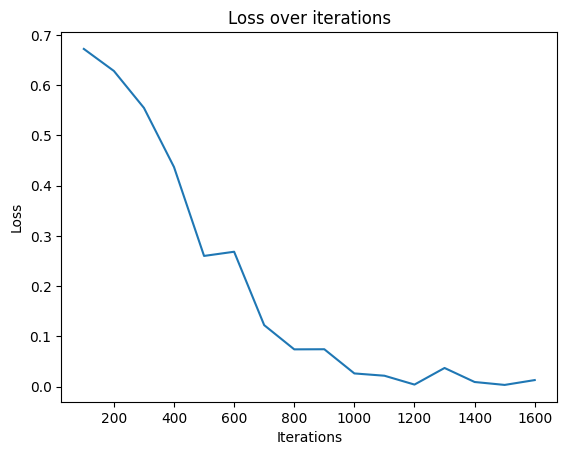

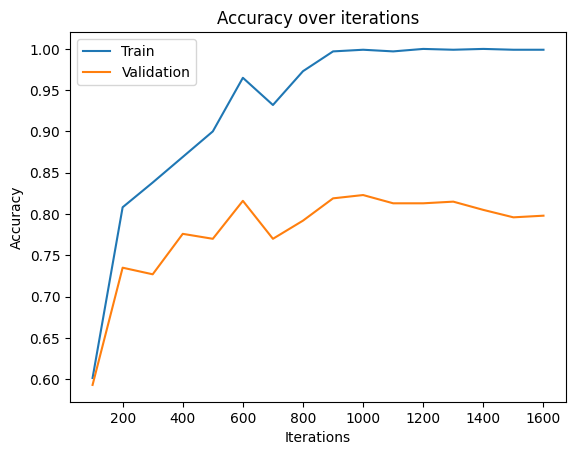

In [ ]:
# RNNmodel = MyRNN(vocab_size=len(eng_vocab)+len(fre_vocab),
#               emb_size=300,
#               hidden_size=64,
#               num_classes=2)
# train_model(RNNmodel, combined_train_indices, combined_val_indices,
#             learning_rate=0.01, num_epochs=6, batch_size=50, plot_every=100)


LSTM_model = MyLSTM(vocab_size=len(eng_vocab)+len(fre_vocab),
                    emb_size=300, hidden_size=64, num_classes=2)
train_model(LSTM_model, combined_train_indices, combined_val_indices,
            learning_rate=0.001, num_epochs=10, batch_size=50, plot_every=100)

Test performance

In [ ]:
# print(f'English: {accuracy(RNNmodel, eng_test_data_indices)}')
# print(f'French: {accuracy(RNNmodel, fre_test_data_indices)}')

In [ ]:
print(f'English Accuracy: {accuracy(LSTM_model, eng_test_data_indices)}')
print(f'French Accuracy: {accuracy(LSTM_model, fre_test_data_indices)}')

English Accuracy: 0.772
French Accuracy: 0.806
